# Assignment 1 BMI260

Segmnetation of lung CT scans

Author: Yusuf Roohani (yroohani@stanford)

## This is the primary test script

## Read in the data

In [1]:
import dicom
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb

from os import listdir
from os.path import join

from mpl_toolkits.mplot3d import Axes3D

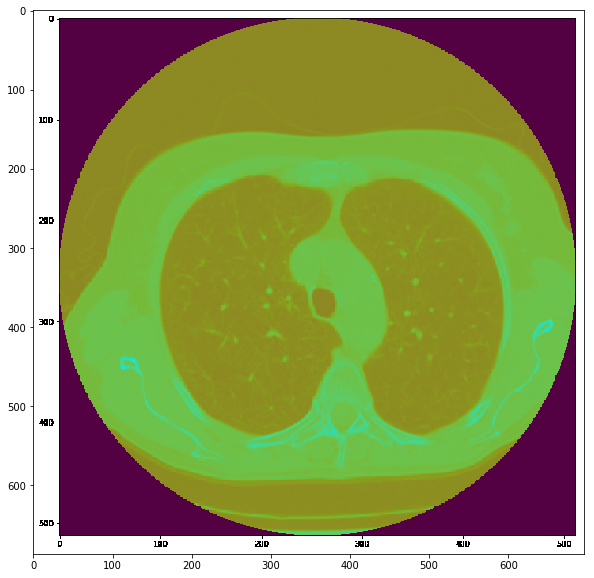

In [9]:
# Read in filenames
#path_dcms = '../kaggle_data...'

# Print out all the .dcm's
#list_dcms = listdir(path_dcms)

# let's just read in the first one.
name_dcm = '../Sample_Imge.png'#list_dcms[10]
img=cv2.imread(name_dcm)
#path_dcm = join(path_dcms, name_dcm)
#dcm = dicom.read_file(path_dcm)

# Let's now display the image.
#img = dcm.pixel_array
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(img)

In [12]:
import mahotas
a = mahotas.features.haralick(img)

In [17]:
a[2].shape

(13,)

In [4]:
dcm.pixel_array_houns = (dcm.RescaleSlope * dcm.pixel_array) + dcm.RescaleIntercept
dcm.pixel_array_houns[dcm.pixel_array_houns > -400] = -400

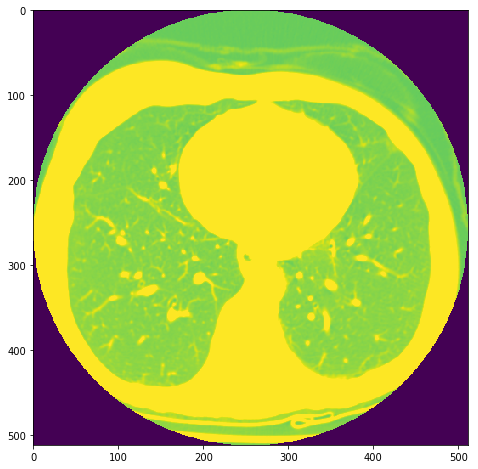

In [5]:
# Let's now display the image.
img = dcm.pixel_array_houns
plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(img)

## Sort the data into an ordered 3D volume

For a given patient, order the slices and store them in a 3D tensor

Normalize the image values to lie between 0 and 1 for easier processing

In [6]:
# Create variables to hold a 3D volume
width = 512; height = 512
depth = len(list_dcms)
lung_vol = np.zeros([width,height,depth])
lung_vol_houns = np.zeros([width,height,depth])

# Create a dictionary to link slice location with image
dcm_slices = {}
dcm_slices_houns = {}

In [7]:
# Stack up all the slices in order
for d in range(depth):
    dcm_file = dicom.read_file(path_dcms + list_dcms[d])
    
    # This is to club bone and other organs into a single broad non-lung class
    dcm_file.pixel_array_houns = (dcm_file.RescaleSlope * dcm_file.pixel_array) + dcm_file.RescaleIntercept
    dcm_file.pixel_array_houns[dcm_file.pixel_array_houns > -450] = -450
    dcm_slices_houns[dcm_file.SliceLocation] = dcm_file.pixel_array_houns
    
    dcm_slices[dcm_file.SliceLocation] = dcm_file.pixel_array
    
sorted_slices = np.sort(dcm_slices.keys())
sorted_slices_houns = np.sort(dcm_slices_houns.keys())

# Now let's make a single volume
for idx,s in enumerate(sorted_slices):
    lung_vol[:,:,idx] = dcm_slices[s]
    lung_vol_houns[:,:,idx] = dcm_slices_houns[s]

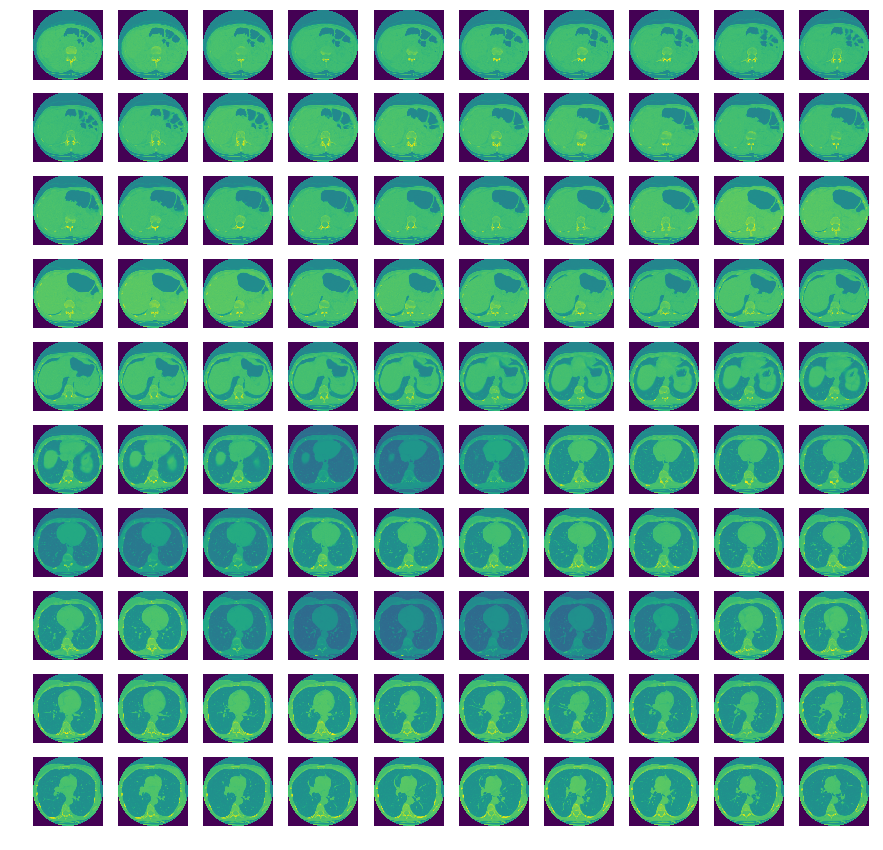

In [13]:
# let's see what these look like in order
fig,ax = plt.subplots(10,10, figsize = (15,15))
d = 0
for i in range(10):
    for j in range(10):
        img = lung_vol[:,:,d]
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        d = d+1
        
# Good, the image sequence makes sense

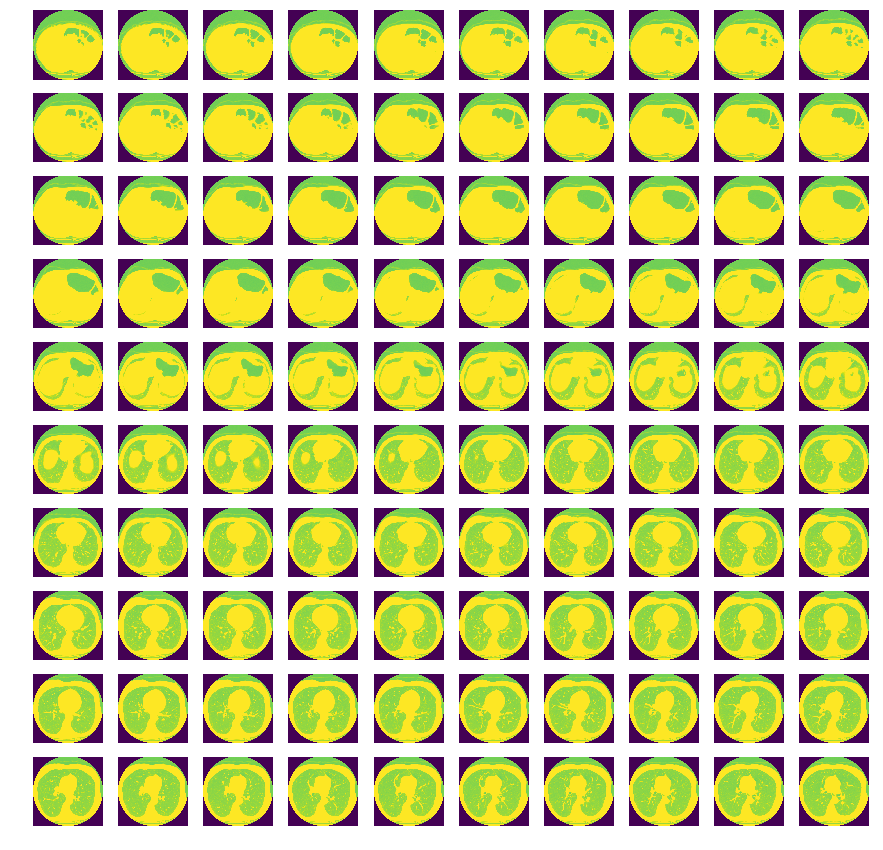

In [28]:
# let's see what these look like in order after clearing out higher hounsfield values
fig,ax = plt.subplots(10,10, figsize = (15,15))
d = 0
for i in range(10):
    for j in range(10):
        img = lung_vol_houns[:,:,d]
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        d = d+1
        
# Good, the image sequence makes sense

In [9]:
# Let's max min normalize these images
#lung_vol_norm = (lung_vol - np.min(lung_vol))/(np.max(lung_vol) - np.min(lung_vol))
lung_vol_norm = (lung_vol_houns - np.min(lung_vol_houns))/(np.max(lung_vol_houns) - np.min(lung_vol_houns))

# Let's check if the normalization worked
print np.min(lung_vol_norm),np.max(lung_vol_norm)

0.0 1.0


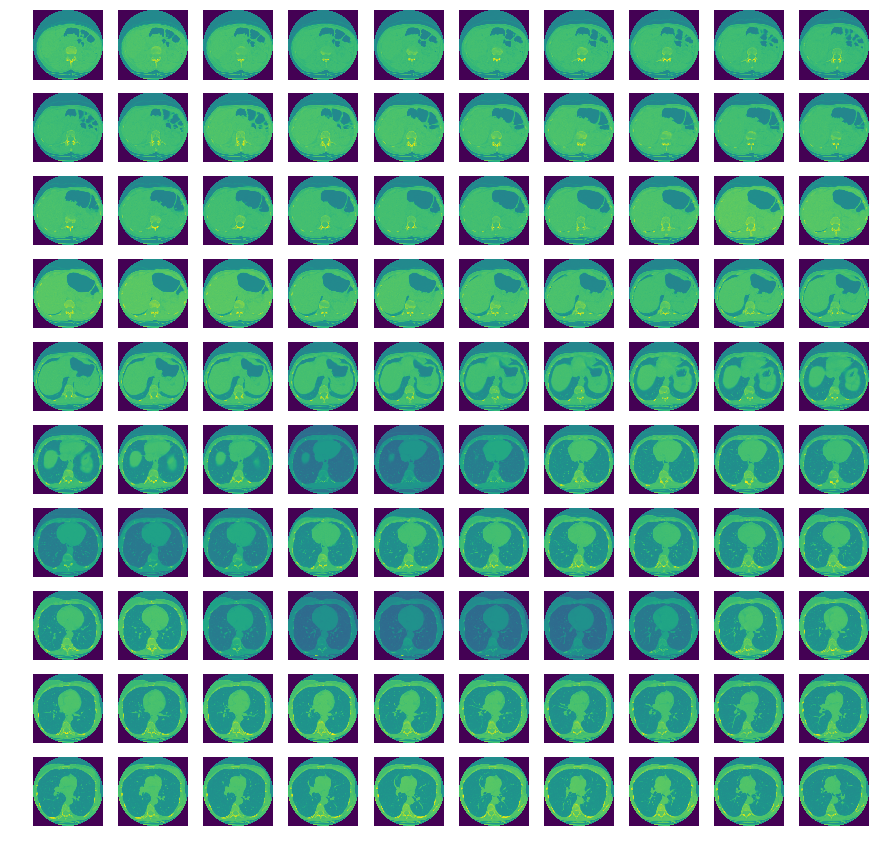

In [8]:
# Good, now that everything is in between 0 and 1, let's also check if the images look the same
fig,ax = plt.subplots(10,10, figsize = (15,15))
d = 0
for i in range(10):
    for j in range(10):
        img = lung_vol_norm[:,:,d]
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        d = d+1
        
# Yup!

## Segmentation

Now, we'll try to separate out the lung from the rest of the slide using
- Otsu thresholding

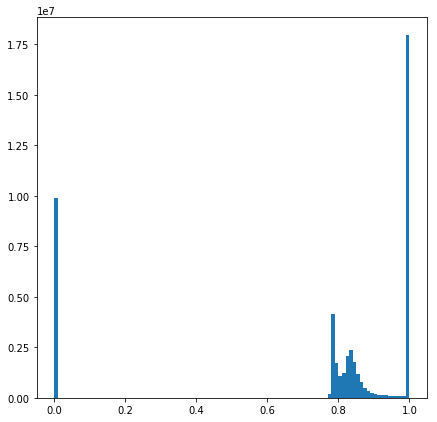

In [10]:
# Visualize the threshold for the 3d image
flat_volume = lung_vol_norm.flatten()
plt.figure(figsize = (7,7))
_ = plt.hist(lung_vol_norm.flatten(), bins = 100)

In [11]:
# There appears to be a clear bimodal distribution, as well as a lot of blank space/zero values
# We can remove those negligible values and perform an Otsu thresholding to get a good split

# By choosing an extremely low cut off (i.e 0.05), we can justify this arbitrary selection of a noise threshold
# since it is very unlikely to affect the signal but would produce a significantly more realistic
# prediction of an Otsu treshold
noise_thresh = 0.05
flat_volume_clean = flat_volume[flat_volume > noise_thresh]

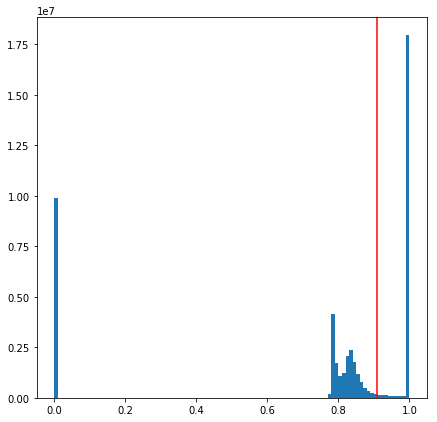

In [12]:
# Here's the Otsu threshold for the cleaned set and it looks like a great estimate
plt.figure(figsize = (7,7))
_ = plt.hist(lung_vol_norm.flatten(), bins = 100)
otsu_thresh = threshold_otsu(flat_volume_clean)
plt.axvline(otsu_thresh, color='r')

In [13]:
# Use the previous calculated Otsu threshold to create a binary image
threshed_image = np.zeros(lung_vol_norm[:,:,100].shape)
threshed_image[lung_vol_norm[:,:,100]>= otsu_thresh]=1

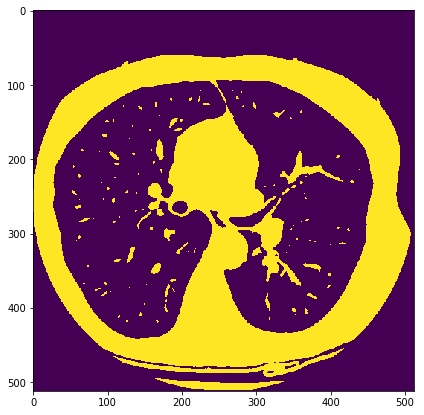

In [14]:
# Let's take a look.
plt.figure(figsize = (7,7))
plt.imshow(threshed_image)

# Looks like a good segmentation of the lungs. Although the outer regions are also getting classfied
# under a similar class, but there's a clear separation between the inner and the outer class
# so it should be straightforward to separate

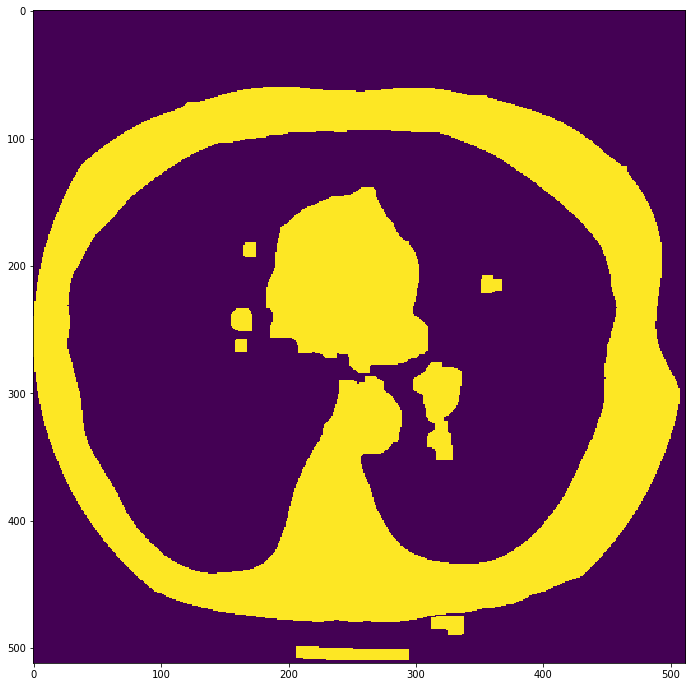

In [26]:
# Let's close up the contours first. We choose a kernel size that's big enough to capture one lung
# but not too big such that it begins to merge the lungs together, or even merge the lung with the outer region

kernel = np.ones((9,9))
closed = cv2.morphologyEx(threshed_image, cv2.MORPH_OPEN, kernel)
plt.imshow(closed)

In [27]:
# Label the different regions using simple connectivity maps
labelled, no_regions = label(closed, background = 1, return_num='TRUE')
print no_regions

# Keep track of the pixels assigned to each region
regions = {}
region_areas = [None]*(no_regions+1)
for r in range(no_regions+1):
    regions[r] = np.where(labelled == r) # Track the pixels themselves
    region_areas[r] = len(regions[r][0]) # As well as the area of the region

2


In [28]:
# These are all the labels that had a presence along the edges
edges = np.concatenate([labelled[1,:], labelled[-1,:], labelled[:,1], labelled[:,-1]])
edge_regions = np.unique(edges)

# Add the background region '0' here too
edge_regions = np.append(edge_regions,0)

In [29]:
# Let's sort the region areas and then remove the edge regions
large_areas = np.argsort(region_areas)[::-1]
inner_areas = [i for i in large_areas if i not in edge_regions]

# Make sure there are enough remaining areas before referencing the list
inner_areas_num = np.min([len(inner_areas),2])
lung_idx = inner_areas[0:inner_areas_num]

In [30]:
# Now create an image with only the selected regions
if len(lung_idx) >= 1:
    labelled[labelled == lung_idx[0]] = 50
if len(lung_idx) == 2:
    labelled[labelled == lung_idx[1]] = 50
labelled[labelled != 50] = 0

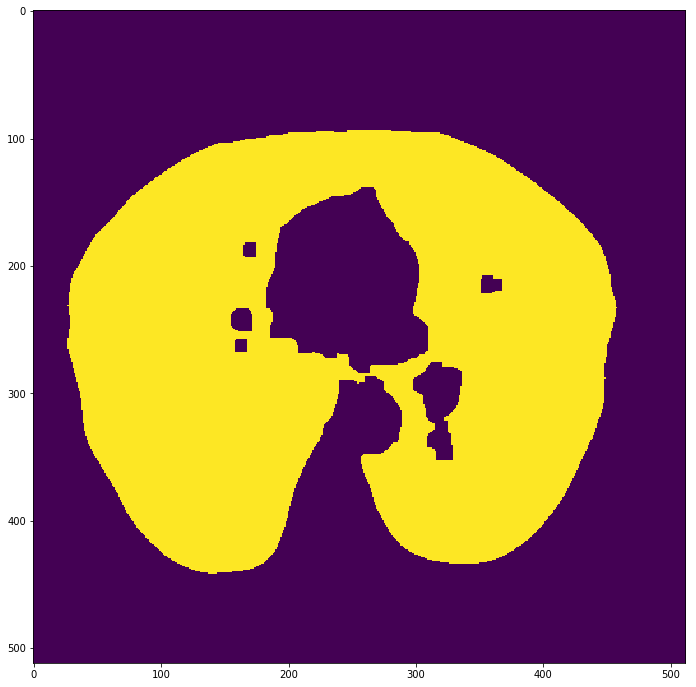

In [31]:
plt.imshow(labelled)

In [18]:
# Now let's functionalize this whole procedure

# This is a function that accepts a lung CT image and segments out the lungs from the background
# It requires a binary treshold value
def lung_segment(image, thresh):
    
    # Use the previous calculated global Otsu threshold to create a binary image
    threshed_image = np.zeros(image.shape)
    threshed_image[image >= thresh]=1
    
    # Let's close up the contours
    kernel = np.ones((4,4))
    closed = cv2.morphologyEx(threshed_image, cv2.MORPH_OPEN, kernel)
    
    # Label the different regions using simple connectivity maps
    labelled, no_regions = label(closed, background = 1, return_num='TRUE')

    # Keep track of the pixels assigned to each region
    regions = {}
    for r in range(no_regions+1):
        regions[r] = np.where(labelled == r) # Track the pixels themselves
        
    # Fine region labels that have a presence along the edges
    edges = np.concatenate([labelled[1,:], labelled[-1,:], labelled[:,1], labelled[:,-1]])
    edge_regions = np.unique(edges)

    # Add the background region '0' here too
    edge_regions = np.append(edge_regions,0)
    
    # Remove the edge regions and background
    select_regions = [i for i in range(no_regions+1) if i not in edge_regions]
    
    # Now create an image with only the selected regions
    for r in select_regions:
        labelled[labelled == r] = 50
    labelled[labelled != 50] = 0
    
    return labelled

## Add a volume/area threshold to get rid of noise

In [32]:
# Let's create a volume of the segmented slices
segmented_slices = np.zeros(lung_vol_norm.shape)
for d in range(lung_vol_norm.shape[2]):
        segmented_slices[:,:,d] = lung_segment(lung_vol_norm[:,:,d], otsu_thresh)/50

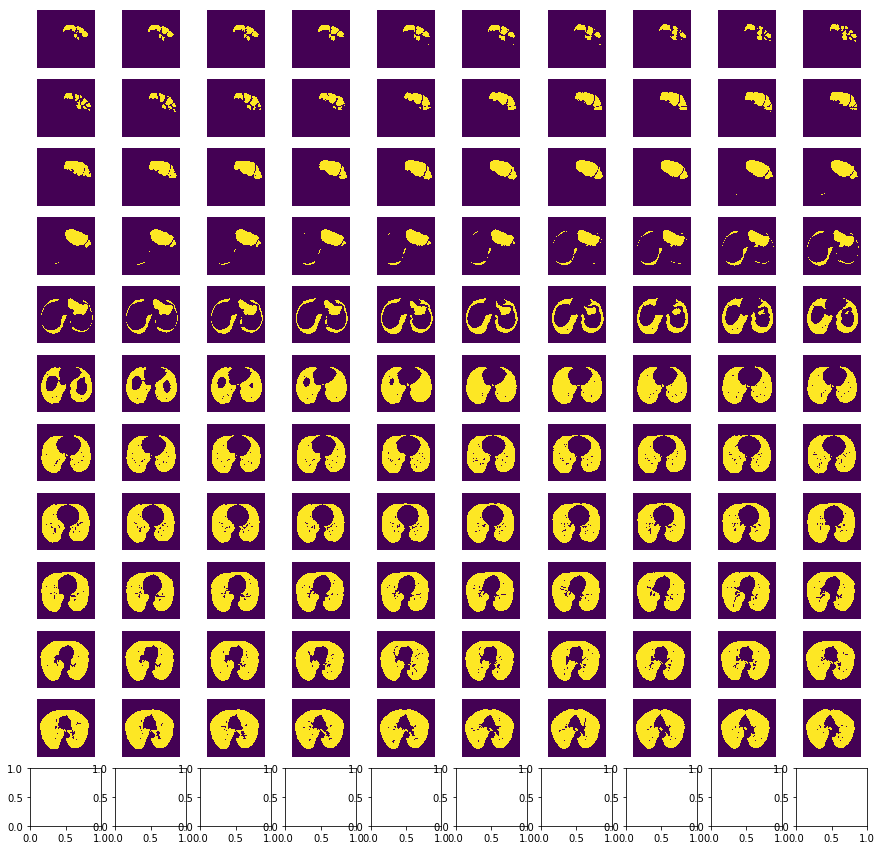

In [15]:
# Let's visualize all the segmented slices
fig,ax = plt.subplots(12,10, figsize = (15,15))
d = 0
for i in range(11):
    for j in range(10):
        img = segmented_slices[:,:,d]
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        d = d+1

In [39]:
# It looks like there's still some noise to clean up. Using the volume instead of the areas may be a good approach
labelled_vols, no_regions = label(segmented_slices, return_num = 'TRUE')
print no_regions

98


In [40]:
regions = {}
volume_thresh = 100000
region_vols = np.zeros(no_regions+1)
for r in range(no_regions+1):
    regions[r] = np.where(labelled_vols == r) # Track the pixels themselves
    region_vols[r] = len(regions[r][0]) # As well as the volume of the region

print region_vols

[  3.76221520e+07   7.99131200e+06   6.00691000e+05   1.00000000e+00
   2.86820000e+04   8.36410000e+04   1.00000000e+00   2.07650000e+04
   2.00000000e+00   2.89600000e+03   6.00000000e+00   1.53200000e+04
   3.70000000e+01   1.87600000e+03   9.29700000e+03   3.00000000e+00
   1.34000000e+02   5.89000000e+02   1.54700000e+03   1.28500000e+03
   2.00000000e+00   1.00000000e+00   9.00000000e+00   1.00000000e+00
   1.30000000e+01   1.20000000e+01   2.00000000e+00   1.50000000e+01
   3.00000000e+00   1.20000000e+01   3.00000000e+00   5.00000000e+00
   5.00000000e+00   2.00000000e+00   1.00000000e+00   3.00000000e+00
   8.00000000e+00   5.00000000e+00   3.00000000e+00   1.00000000e+00
   2.00000000e+00   2.00000000e+01   6.00000000e+00   7.00000000e+00
   2.00000000e+00   1.00000000e+00   3.00000000e+00   2.51000000e+02
   3.10000000e+02   1.04000000e+02   7.45000000e+02   9.00000000e+01
   4.36000000e+02   2.94000000e+02   3.20000000e+01   1.83000000e+02
   1.68000000e+02   4.71000000e+02

In [47]:
select_vols = np.where(region_vols > volume_thresh)[0][1:] # Remove the first element becuase it's background
select_vols = [1]
for r in select_vols:
    print r
    print sum(labelled_vols[labelled_vols == r])
    labelled_vols[labelled_vols == r] = -1
labelled_vols[labelled_vols != -1] = 0
labelled_vols[labelled_vols == -1] = 1

1
7991312


## 3D visualizations

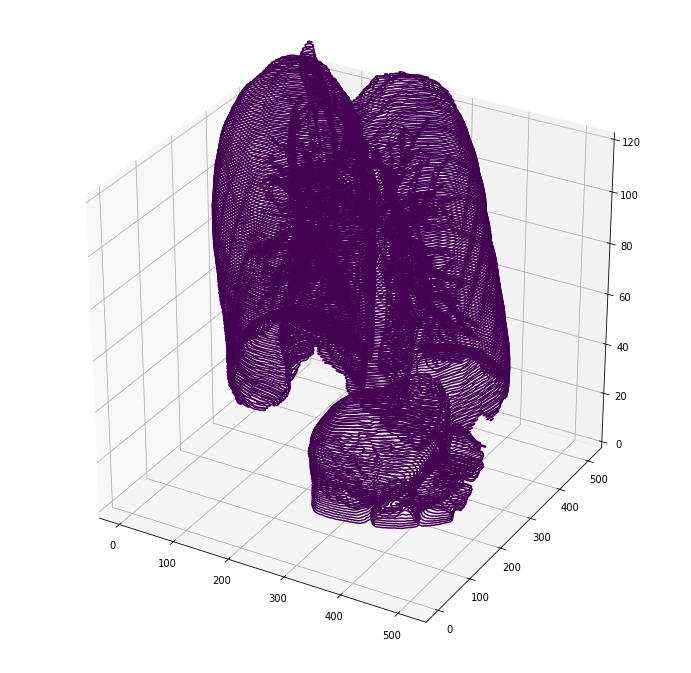

In [19]:
# Create a 3D visualization
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim([0,120])
X = np.tile(np.arange(512),[512,1])
Y = np.transpose(np.tile(np.arange(512),[512,1]))

for i in range(labelled_vols.shape[2]):
    ax.contour(X, Y, labelled_vols[:,:,i]*(i+1), levels = [ i])

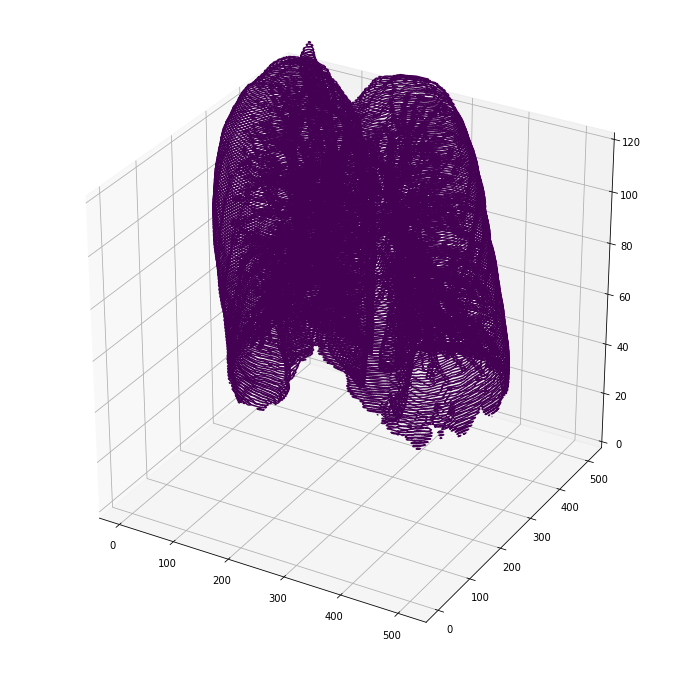

In [48]:
# Create a 3D visualization
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim([0,120])
X = np.tile(np.arange(512),[512,1])
Y = np.transpose(np.tile(np.arange(512),[512,1]))

for i in range(labelled_vols.shape[2]):
    ax.contour(X, Y, labelled_vols[:,:,i]*(i+1), levels = [ i])

## Marching cubes for 3D visualization

In [97]:
from skimage.measure import marching_cubes_lewiner
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = marching_cubes_lewiner(labelled_vols, 0, step_size=1)

In [98]:
faces.shape

(2050050, 3)

In [99]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

#ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
#ax.set_ylim(0, 20)  # b = 10
#ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Saving images for Fiji visualization

In [173]:
from os import mkdir
from os.path import join,isdir
import scipy.misc

# Path of the saved images.  CHANGE THIS FOR YOUR COMPUTER.
path_save = './lung_3d/'
if not isdir(path_save):
    mkdir(path_save)

# Loop over all images to save.
for i in range(labelled_vols.shape[2]):
    path_save_img = path_save + str(i)+'.png'
    scipy.misc.imsave(path_save_img, labelled_vols[:,:,i])